### Import modules

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display

from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Flatten

### Load data

In [3]:
data_path = '../data/raw'

genres = os.listdir(data_path)
print("Genres disponibles :", genres)

for genre in genres:
    files = os.listdir(os.path.join(data_path, genre))
    print(f"Genre: {genre}, Nombre de fichiers: {len(files)}")
    print(f"Premiers fichiers: {files[:5]}")

Genres disponibles : ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Genre: blues, Nombre de fichiers: 100
Premiers fichiers: ['blues.00000.au', 'blues.00001.au', 'blues.00002.au', 'blues.00003.au', 'blues.00004.au']
Genre: classical, Nombre de fichiers: 100
Premiers fichiers: ['classical.00000.au', 'classical.00001.au', 'classical.00002.au', 'classical.00003.au', 'classical.00004.au']
Genre: country, Nombre de fichiers: 100
Premiers fichiers: ['country.00000.au', 'country.00001.au', 'country.00002.au', 'country.00003.au', 'country.00004.au']
Genre: disco, Nombre de fichiers: 100
Premiers fichiers: ['disco.00000.au', 'disco.00001.au', 'disco.00002.au', 'disco.00003.au', 'disco.00004.au']
Genre: hiphop, Nombre de fichiers: 100
Premiers fichiers: ['hiphop.00000.au', 'hiphop.00001.au', 'hiphop.00002.au', 'hiphop.00003.au', 'hiphop.00004.au']
Genre: jazz, Nombre de fichiers: 100
Premiers fichiers: ['jazz.00000.au', 'jazz.00001.au', 'jazz.00002

### Visualize audio file

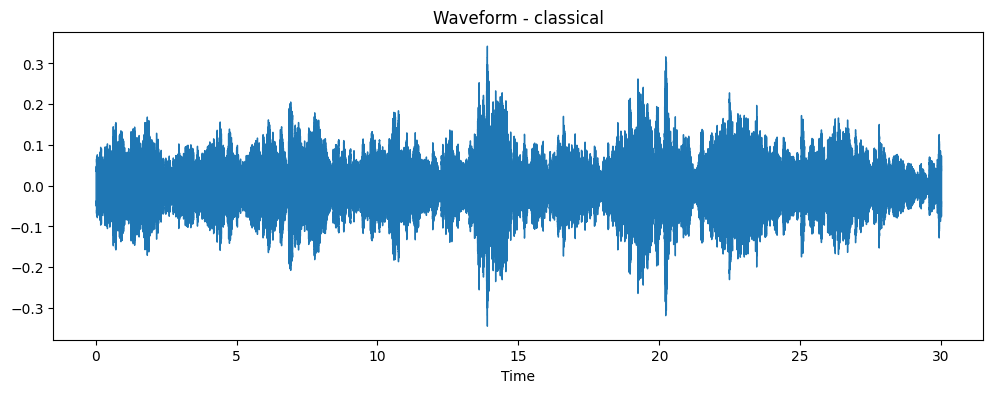

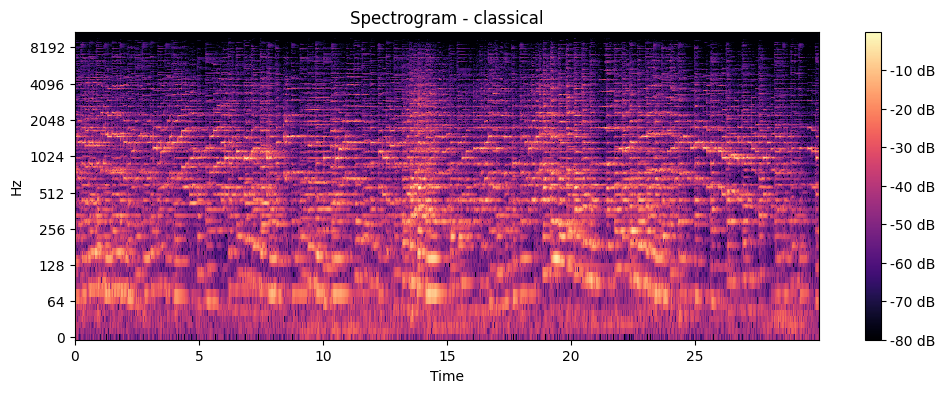

In [4]:
genre_example = 'classical'
file_example = os.path.join(data_path, genre_example, os.listdir(os.path.join(data_path, genre_example))[0])
y, sr = librosa.load(file_example, duration=30)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f'Waveform - {genre_example}')
plt.show()

plt.figure(figsize=(12, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram - {genre_example}')
plt.show()

### Visualize audio features

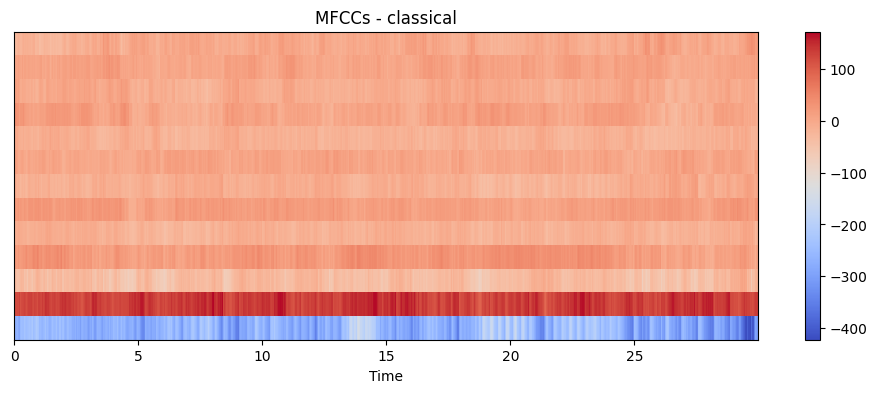

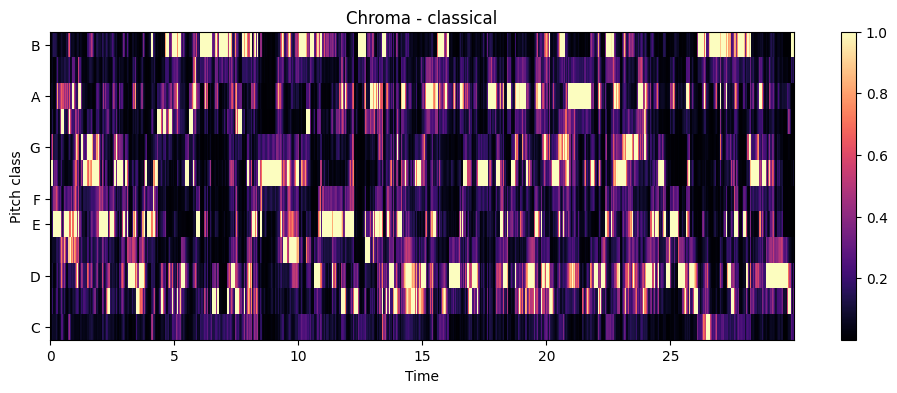

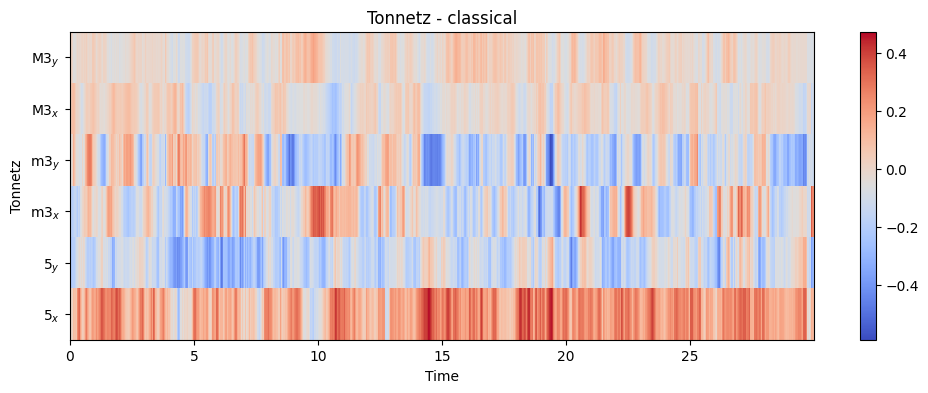

In [5]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title(f'MFCCs - {genre_example}')
plt.show()

chroma = librosa.feature.chroma_stft(y=y, sr=sr)
plt.figure(figsize=(12, 4))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title(f'Chroma - {genre_example}')
plt.show()

tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
plt.figure(figsize=(12, 4))
librosa.display.specshow(tonnetz, sr=sr, x_axis='time', y_axis='tonnetz')
plt.colorbar()
plt.title(f'Tonnetz - {genre_example}')
plt.show()

### Process and prepare data

In [83]:
def extract_instrument_features(file_path):
    y, sr = librosa.load(file_path, duration=240)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features = np.hstack([np.mean(mfccs.T, axis=0), np.mean(chroma.T, axis=0),
                          np.mean(spectral_contrast.T, axis=0), np.mean(tonnetz.T, axis=0),
                          np.mean(zero_crossing_rate.T, axis=0), np.mean(spectral_centroid.T, axis=0),
                          np.mean(spectral_bandwidth.T, axis=0), np.mean(spectral_rolloff.T, axis=0)])
    return features

In [84]:
all_features = []
all_labels = []

for genre in genres:
    for file in os.listdir(os.path.join(data_path, genre)):
        file_path = os.path.join(data_path, genre, file)
        features = extract_instrument_features(file_path)
        all_features.append(features)
        all_labels.append(genre)

df_features = pd.DataFrame(all_features)
df_labels = pd.Series(all_labels)

print("Dataset size :", df_features.shape)

Dataset size : (1000, 42)


In [85]:
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,-113.598824,121.570671,-19.162262,42.363941,-6.362266,18.621931,-13.699734,15.339803,-12.274304,10.970945,...,0.026548,0.018225,0.004865,-0.016635,0.009777,-0.004213,0.083045,1784.122641,2002.412407,3805.723030
1,-207.523834,123.985138,8.947019,35.867149,2.909595,21.519472,-8.556513,23.370676,-10.103608,11.899242,...,0.035600,0.084445,0.041464,0.007970,0.020628,-0.013831,0.056040,1530.261767,2038.987608,3550.713616
2,-90.757164,140.440872,-29.084547,31.686693,-13.976547,25.753752,-13.664990,11.634442,-11.778322,9.714756,...,0.120100,-0.065075,0.066093,0.043726,0.000170,-0.019680,0.076291,1552.832481,1747.754087,3042.410115
3,-199.575134,150.086105,5.663404,26.855278,1.770071,14.232647,-4.827845,9.286853,-0.756120,8.134435,...,0.102029,-0.061807,0.086822,0.074737,-0.005001,-0.036803,0.033309,1070.153418,1596.422564,2184.879029
4,-160.354172,126.209480,-35.581394,22.139256,-32.473549,10.850702,-23.350071,0.493249,-11.796538,1.203519,...,-0.005248,0.060673,-0.158578,-0.010759,0.017170,-0.028944,0.101461,1835.128513,1748.410758,3579.957471


### Save processed data

In [86]:
df_features.to_csv('../data/processed/features.csv', index=False)
df_labels.to_csv('../data/processed/labels.csv', index=False)

### Select features

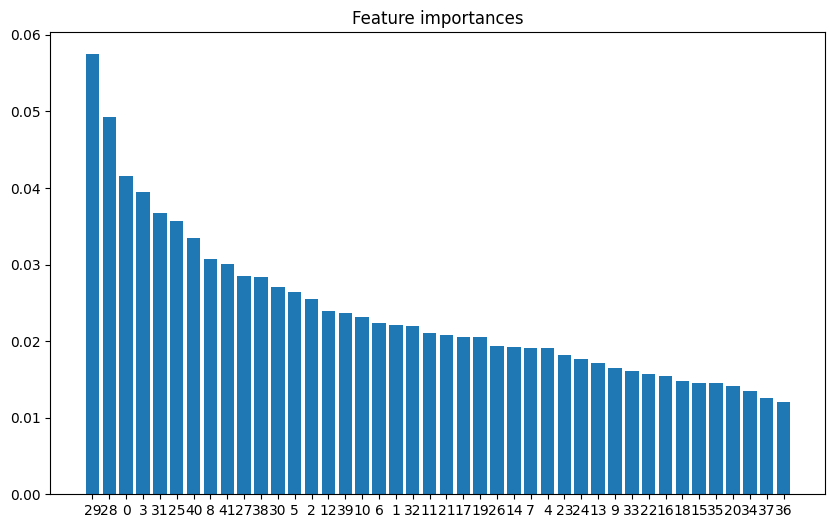

In [115]:
X = df_features.values
y = df_labels.values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

importances = RandomForestClassifier().fit(X, y_encoded).feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.show()

In [126]:
importance_threshold = 0.015
important_features_indices = [i for i, importance in enumerate(importances) if importance >= importance_threshold]

X_filtered = X[:, important_features_indices]

print(f"Number of selected features : {len(important_features_indices)}")

Number of selected features : 35


### Prepare data

In [127]:
scaler = StandardScaler()
X_filtered = scaler.fit_transform(X_filtered)

X_reshaped = X_filtered.reshape((X_filtered.shape[0], X_filtered.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (800, 35, 1)
Test data shape: (200, 35, 1)


In [128]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print(f"y_train_encoded shape: {y_train_encoded.shape}") 

y_train_encoded shape: (800, 10)


### Construct classification models

In [156]:
model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(y_train_encoded.shape[1], activation='softmax'))
optimizer = Adam(learning_rate=0.0012)
model_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_gru = Sequential()
model_gru.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(128))
model_gru.add(Dropout(0.1))
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dense(y_train_encoded.shape[1], activation='softmax'))
optimizer = Adam(learning_rate=0.0008)
model_gru.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_cnn = Sequential()
model_cnn.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(128, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(y_train_encoded.shape[1], activation='softmax'))
optimizer = Adam(learning_rate=0.0008)
model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

C:\Users\flavi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\flavi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Train classification models

In [157]:
model_lstm.fit(X_train, y_train_encoded, epochs=150, batch_size=32, validation_data=(X_test, y_test_encoded))
model_gru.fit(X_train, y_train_encoded, epochs=150, batch_size=32, validation_data=(X_test, y_test_encoded))
model_cnn.fit(X_train, y_train_encoded, epochs=150, batch_size=32, validation_data=(X_test, y_test_encoded))

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.1869 - loss: 2.2272 - val_accuracy: 0.1600 - val_loss: 2.1209
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.2985 - loss: 1.9064 - val_accuracy: 0.3650 - val_loss: 1.8766
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.3715 - loss: 1.7337 - val_accuracy: 0.3700 - val_loss: 1.7551
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3894 - loss: 1.6357 - val_accuracy: 0.3150 - val_loss: 1.8216
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4363 - loss: 1.5942 - val_accuracy: 0.4000 - val_loss: 1.6962
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4248 - loss: 1.5057 - val_accuracy: 0.4200 - val_loss: 1.6959
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4970 - loss: 1.4291 - val_accuracy: 0.4200 - val_loss: 1.6798
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4716 - loss: 1.4322 - val_accuracy: 0.

### Evaluate classification models

In [158]:
preds_lstm = model_lstm.predict(X_test)
preds_gru = model_gru.predict(X_test)
preds_cnn = model_cnn.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [159]:
lstm_preds_avg = np.mean([preds_lstm], axis=0)
gru_preds_avg = np.mean([preds_gru], axis=0)
cnn_preds_avg = np.mean([preds_cnn], axis=0)

lstm_preds_avg_class = np.argmax(lstm_preds_avg, axis=1)
gru_preds_avg_class = np.argmax(gru_preds_avg, axis=1)
cnn_preds_avg_class = np.argmax(cnn_preds_avg, axis=1)

lstm_accuracy_avg = accuracy_score(np.argmax(y_test_encoded, axis=1), lstm_preds_avg_class)
gru_accuracy_avg = accuracy_score(np.argmax(y_test_encoded, axis=1), gru_preds_avg_class)
cnn_accuracy_avg = accuracy_score(np.argmax(y_test_encoded, axis=1), cnn_preds_avg_class)

print(f'LSTM accuracy: {lstm_accuracy_avg}')
print(f'GRU accuracy: {gru_accuracy_avg}')
print(f'CNN accuracy: {cnn_accuracy_avg}')

LSTM accuracy: 0.48
GRU accuracy: 0.56
CNN accuracy: 0.67


In [160]:
preds_avg = np.mean([preds_lstm, preds_gru, preds_cnn], axis=0)
preds_avg_class = np.argmax(preds_avg, axis=1)
accuracy_avg = accuracy_score(np.argmax(y_test_encoded, axis=1), preds_avg_class)
print(f'Average accuracy: {accuracy_avg}')

Average accuracy: 0.645


In [161]:
lstm_preds_concat = np.array([np.argmax(preds_lstm, axis=1)])
gru_preds_concat = np.array([np.argmax(preds_gru, axis=1)])
cnn_preds_concat = np.array([np.argmax(preds_cnn, axis=1)])

lstm_preds_vote = mode(lstm_preds_concat, axis=0)[0]
gru_preds_vote = mode(gru_preds_concat, axis=0)[0]
cnn_preds_vote = mode(cnn_preds_concat, axis=0)[0]

lstm_accuracy_vote = accuracy_score(np.argmax(y_test_encoded, axis=1), lstm_preds_vote)
gru_accuracy_vote = accuracy_score(np.argmax(y_test_encoded, axis=1), gru_preds_vote)
cnn_accuracy_vote = accuracy_score(np.argmax(y_test_encoded, axis=1), cnn_preds_vote)

print(f'LSTM vote accuracy: {lstm_accuracy_vote}')
print(f'GRU vote accuracy: {gru_accuracy_vote}')
print(f'CNN vote accuracy: {cnn_accuracy_vote}')

LSTM vote accuracy: 0.48
GRU vote accuracy: 0.56
CNN vote accuracy: 0.67


In [162]:
preds_concat = np.array([np.argmax(preds_lstm, axis=1), np.argmax(preds_gru, axis=1), np.argmax(preds_cnn, axis=1)])
preds_vote = mode(preds_concat, axis=0)[0]

accuracy_vote = accuracy_score(np.argmax(y_test_encoded, axis=1), preds_vote)
print(f'Vote accuracy: {accuracy_vote}')

Vote accuracy: 0.62


### Confusion matrix

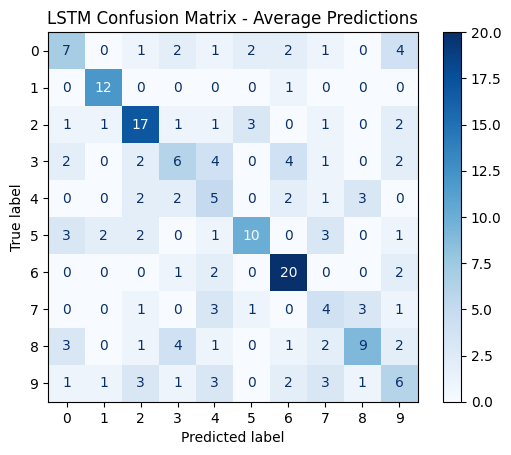

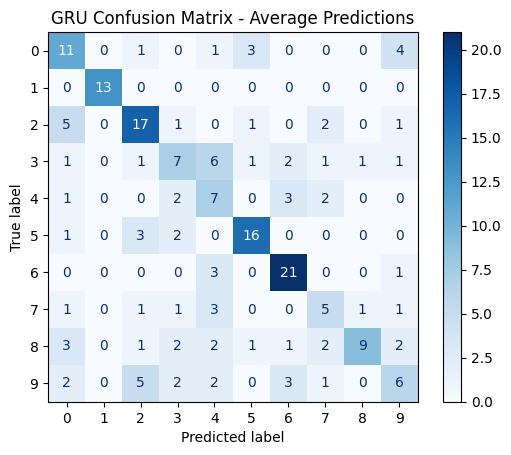

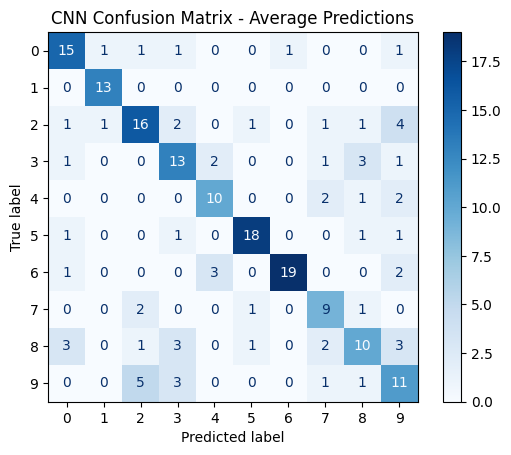

In [165]:
ltsm_preds_avg_class = np.argmax(np.mean([preds_lstm], axis=0), axis=1)
gru_preds_avg_class = np.argmax(np.mean([preds_gru], axis=0), axis=1)
cnn_preds_avg_class = np.argmax(np.mean([preds_cnn], axis=0), axis=1)

lstm_cm_avg = confusion_matrix(np.argmax(y_test_encoded, axis=1), ltsm_preds_avg_class)
gru_cm_avg = confusion_matrix(np.argmax(y_test_encoded, axis=1), gru_preds_avg_class)
cnn_cm_avg = confusion_matrix(np.argmax(y_test_encoded, axis=1), cnn_preds_avg_class)

disp = ConfusionMatrixDisplay(confusion_matrix=lstm_cm_avg)
disp.plot(cmap=plt.cm.Blues)
plt.title("LSTM Confusion Matrix - Average Predictions")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=gru_cm_avg)
disp.plot(cmap=plt.cm.Blues)
plt.title("GRU Confusion Matrix - Average Predictions")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=cnn_cm_avg)
disp.plot(cmap=plt.cm.Blues)
plt.title("CNN Confusion Matrix - Average Predictions")
plt.show()